# Import Libraries

In [1]:
#!pip install --upgrade scipy
#!pip install plotly
import nibabel as nib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import f
from scipy.special import betainc
from scipy.stats import norm, f
from scipy.ndimage import rotate
import re
import plotly.express as px

# Define Parameters

In [2]:
# Define parameters
d = [0.05]#, 0.01, 0.005, 0.001]
f2 = [0.3]#, 0.2, 0.3]
df = [1]#, 2, 3]
Ns = [150]#[50, 100, 150, 200]

# Define Functions

In [3]:
# Function to load NIfTI images
def load_nii(filename):
    return nib.load(filename)

# Function to compute z-score from alpha
def z_score_from_alpha(alpha, tail='two-sided'):
    """
    Calculates the z-score from a given alpha value.

    Parameters:
    alpha (float): Significance level (e.g., 0.05).
    tail (str): Type of test tail ('two-sided', 'left', or 'right').
                  Defaults to 'two-sided'.

    Returns:
    float: Z-score corresponding to the alpha value.
    """
    if tail == 'two-sided':
        z = norm.ppf(1 - alpha/2)
    elif tail == 'left':
        z = norm.ppf(alpha)
    elif tail == 'right':
         z = norm.ppf(1 - alpha)
    else:
        raise ValueError("tail must be 'two-sided', 'left', or 'right'")
    return z


# Function for power and statistic p-value calculations
def power_calcs2(df1, df2, cohens_f2, alpha, Contrast_img):

    Fcrit = f.ppf(1 - alpha, df1, df2) # returns the inverse cumulative distribution function of the F distribution with degrees of freedom df1 and df2, evaluated at the probability value of 1 - alpha

    SPM_ZtoP = 2 * (1 - norm.cdf(Contrast_img)) #where SPM_Zobs was hardcoded 1.75 - do we need the absolute value of the zscore?

    lambda_ = (df1 + df2 + 1) * cohens_f2
    kappa = (df1 + lambda_) / df1
    df2_lambda = ((df1 + lambda_) ** 2) / (df1 + 2 * lambda_)

    F_prime = Fcrit / kappa
    x = (df2_lambda * F_prime) / (df2 + df2_lambda * F_prime)
    beta = betainc(df2_lambda / 2, df2 / 2, x)

    power = 1 - beta

    return power, SPM_ZtoP


# Function for second generation p-value calculations
def calculate_second_gen_p_value(observed_effect, null_hypothesis, effect_interval, n, alpha):
    """
    Calculate second-generation p-value for neuroimaging data
    
    Parameters:
        observed_effect (float): Estimated effect size from neuroimaging analysis - Contrast_img (z scores)
        null_hypothesis (float): Point null hypothesis value #### this should be the mean of the population (which for fmri is 0)
        effect_interval (float): Interval of practically equivalent effects - Contrast_Scaled (cohen's f^2 based on f2 power value)
    
    Returns:
        tuple: (delta_p, interpretation)
    """

    #Calculate standard deviation 
    std = z_score_from_alpha(alpha, tail='two-sided') # assuming 1-tailed test (1.64 at alpha 0.05) - need to take into account both tails
    
    # Standard error calculated from the sample size and standard deviation (from the alpha value)
    std_error = std / np.sqrt(n-1) # n-1 because t-tests
    #print(std_error)

    # Transform cohen's f^2 to cohen's d (effect_interval) using formula d = 2f / √(1 - f²) *** may be wrong formula ***
    #effect_interval = (2*np.sqrt(effect_interval))/(np.sqrt(1-effect_interval))
    # Transform z score to cohen's d
    effect_interval = observed_effect/ np.sqrt(n-1) #https://www.researchgate.net/post/Is_cohen_d_equal_to_z_statistics_How_can_I_calculate_cohen_d_using_Z_scores
    
    #CI of each voxel
    # Lower and upper bounds of confidence interval
    ci_lower = observed_effect - std_error # observed_effect is the z_score and std error is the variance/CI around the z score
    #print(ci_lower)
    ci_upper = observed_effect + std_error
    #print(ci_upper)
    
    #H0 of overall study
    # Lower and upper bounds of effect interval
    interval_lower = null_hypothesis - effect_interval # null hypothesis 0 +/- cohen's d
    #print(interval_lower)
    interval_upper = null_hypothesis + effect_interval
    #print(interval_upper)
    
    # Calculate second-generation p-value
    if ci_upper <= interval_upper and ci_lower >= interval_lower: #CI entirely contained in the indifference zone (interval)
        # Conclusive evidence against null
        delta_p = 1.0
        #interpretation = 'The data supports the null hypothesis - not scientifically or clinically meaningful'
    elif ci_upper < interval_lower or ci_lower > interval_upper: #absolutely no overlap of CI with the indifference zone 
        # Confidence interval completely covers equivalence interval
        delta_p = 0.0
        #interpretation = 'The data supports an alternative hypothesis that is scientifically OR clinically meaningful'
    elif (ci_upper - ci_lower) > (2*(interval_upper-interval_lower)): 
        # Confidence interval more than twice the length of the null interval (p.4 and top p.6)
        delta_p = 0.5
        #interpretation = 'Data is strictly inconclusive'
    else: 
        # Confidence interval less than twice the length of the null interval (p.4)
        # Partial overlap (either above or below null interval) - ### is there a situation in which it could be both?
        overlap_lower = max(ci_lower, interval_lower)
        overlap_upper = min(ci_upper, interval_upper)
        
        # Calculate proportion of overlap
        delta_p = (overlap_upper - overlap_lower) / (ci_upper - ci_lower)
        #interpretation = 'Partial evidence, some consistency with null' #overlap fraction
         
    return delta_p


# Get Power, P-Val, and 2nd Gen P-Val and Each Voxel (Contrast Images)
### Looped for each f2, sample size (N), and alpha

In [4]:
Contrast = load_nii('auditory_association-test_z_FDR_0.01.nii.gz')

# Extract image data
Contrast_img = Contrast.get_fdata()
print(Contrast_img.flatten().min())
print(Contrast_img.flatten().mean())
print(Contrast_img.flatten().max())
img = Contrast_img.flatten()
result = [x for x in img if x != 0]
print(result)
for value in img:
        if (-3 <= value <= 3) & (value !=0.0):
            print(value)

-5.611618820207422
0.11085793275322016
26.288217871050875
[3.5137642210893523, 3.7094142191174924, 3.988629921179741, 4.824888316283279, 4.544803402601746, 4.228830510930203, 4.542847911285643, 4.673874951342386, 5.982103855572805, 5.271978786765988, 5.87008262218959, 5.392167197208711, 3.9221190936106503, 4.7585488992546, 6.513395707483164, 7.083894772782933, 6.429907886683731, 7.398606902671514, 8.582083358628621, 6.965407640183112, 6.307318667229966, 4.888991125032402, 4.544803402601746, 6.299223740848833, 8.19708265456612, 9.584855542713717, 8.87605701523863, 9.170030671848645, 8.160441302281408, 8.142764810129124, 7.1605502493017585, 6.302236101353081, 4.527654450202195, 4.544803402601746, 7.535118211062775, 8.17993426376878, 10.40662879330351, 9.697958334172457, 10.615099268663908, 8.893578922307766, 9.601977910491623, 7.824203027665849, 6.396913015370999, 5.466803025922828, 4.972926869054187, 4.002215573011632, 5.7362365868960845, 9.822762164399936, 10.518111501790202, 11.310481

In [5]:
# Load fMRI images
MNIAtlas = load_nii('anatomical.nii.gz')
#Contrast = load_nii('language_uniformity-test_z_FDR_0.01.nii.gz')
Contrast = load_nii('language_association_test_z_FDR_0.01.nii.gz')

# Extract image data
Contrast_img = Contrast.get_fdata()

# Compute max contrast
MaxContrast = np.max(Contrast_img)

for a in f2:
    # Scale contrast images
    Contrast_Scaled = (a / MaxContrast) * Contrast_img

    # Get image dimensions correctly
    XDIM, YDIM, ZDIM = Contrast_img.shape
    PowerImage = np.zeros((XDIM, YDIM, ZDIM))
    PvalImage = np.zeros((XDIM, YDIM, ZDIM))
    SecGenPvalImage = np.zeros((XDIM, YDIM, ZDIM))

    for n in Ns:
        for alpha in d:
            for i in range(XDIM):
                for j in range(YDIM):
                    for k in range(ZDIM):
                        if Contrast_Scaled[i, j, k] != 0: ##### Shouldn't this  be != 0 - not >0? There are negative z scores
                            stat_power, _ = power_calcs2(1, n, Contrast_Scaled[i, j, k], alpha, Contrast_img[i, j, k]) # only calculate power on non-0 values
                        if Contrast_img[i, j, k] != 0:
                            _ , stat_pval = power_calcs2(1, n, Contrast_img[i, j, k], alpha, Contrast_img[i, j, k])
                            secgenpval = calculate_second_gen_p_value(Contrast_img[i, j, k], 0, Contrast_Scaled[i, j, k], n, alpha)
                            
                            # Power analysis
                            PowerThreshold = 1 - a
                            if stat_power >= PowerThreshold:
                                PowerImage[i, j, k] = stat_power #adjusts 3d matrix on values to only include power values that meet threshold (overwrites default zeros)
                            # Pval analysis
                            if stat_pval <= alpha:
                                PvalImage[i, j, k] = stat_pval 
                            # Second Gen Pval analysis
                            if secgenpval <= 0.5:
                                SecGenPvalImage[i, j, k] = secgenpval 

            # Format filename correctly
            pvalue = str(alpha).replace('0.', '')
            f2value = str(a).replace('0.', '0')

            # Save power image as a NIfTI file
            power_filename = f'images/PowerContrast_N{n}_p{pvalue}_Power{int(PowerThreshold * 100)}_f2{f2value}.nii.gz'
            print(power_filename)
            PowerImage_nii = nib.Nifti1Image(PowerImage, Contrast.affine, Contrast.header)
            nib.save(PowerImage_nii, power_filename)

            # Save pval image as a NIfTI file
            pval_filename = f'images/PValContrast_N{n}_p{pvalue}_Power{int(PowerThreshold * 100)}_f2{f2value}.nii.gz'
            print(pval_filename)
            PvalImage_nii = nib.Nifti1Image(PvalImage, Contrast.affine, Contrast.header)
            nib.save(PvalImage_nii, pval_filename)

            # Save second gen pval image as a NIfTI file
            secgenpval_filename = f'images/SecGenPValContrast_N{n}_p{pvalue}_Power{int(PowerThreshold * 100)}_f2{f2value}.nii.gz'
            print(secgenpval_filename)
            SecGenPvalImage_nii = nib.Nifti1Image(SecGenPvalImage, Contrast.affine, Contrast.header)
            nib.save(SecGenPvalImage_nii, secgenpval_filename)


images/PowerContrast_N150_p05_Power70_f203.nii.gz
images/PValContrast_N150_p05_Power70_f203.nii.gz
images/SecGenPValContrast_N150_p05_Power70_f203.nii.gz


# Activation Maps - Power

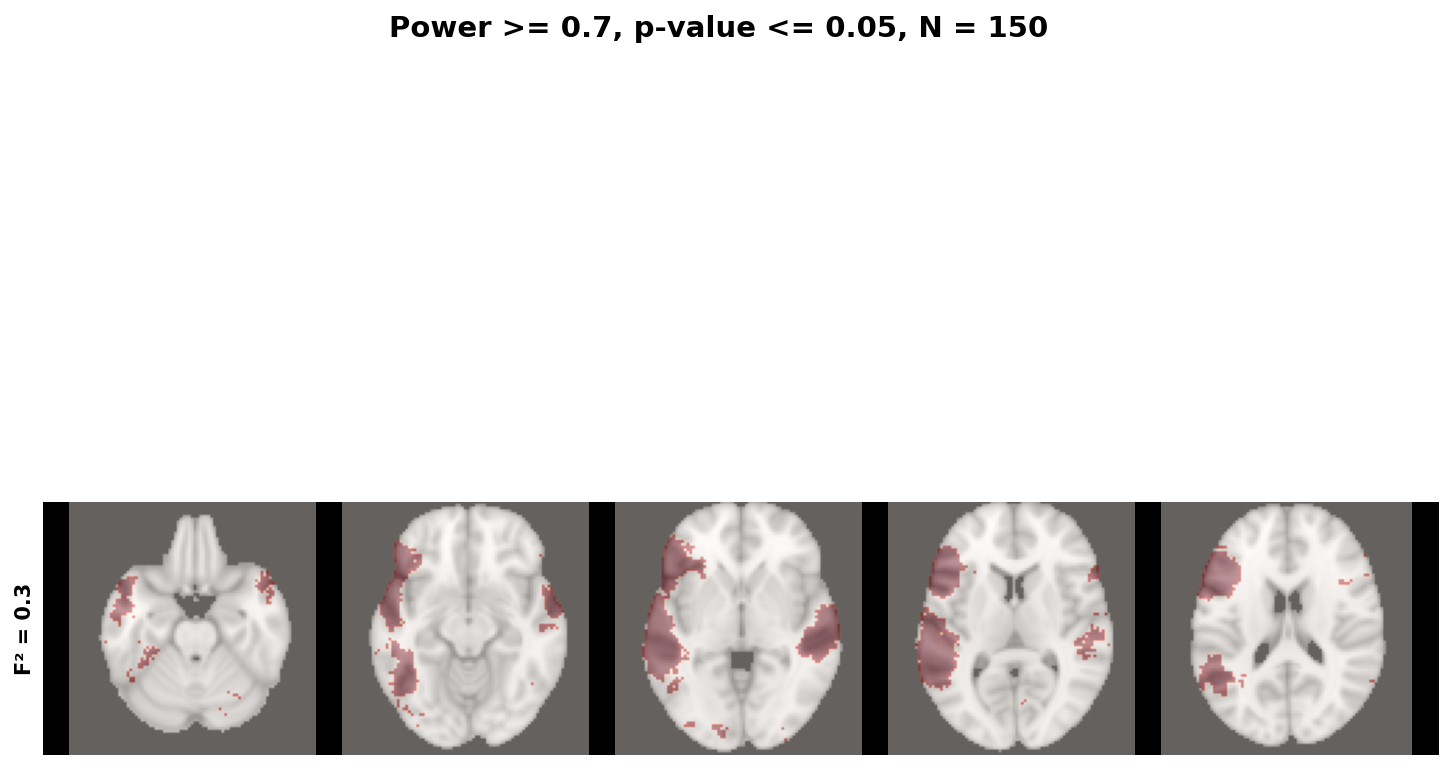

In [6]:
# Define the activation files
activation_files = [
    'images/PowerContrast_N150_p05_Power70_f203.nii.gz'
]

# Load the anatomical image
img = nib.load('anatomical.nii.gz')
data = img.get_fdata()

# Define slices to extract
slices_indices = [24, 30, 35, 40, 45]

# Set up the figure
fig, axes = plt.subplots(len(activation_files), len(slices_indices), figsize=(12, 9), dpi=150)

# Loop through activation files
for row, activation_file in enumerate(activation_files):
    # Load activation data
    activation = nib.load(activation_file)
    activation_data = activation.get_fdata()
    
    # Extract metadata from filename
    match = re.search(r'images/PowerContrast_N(\d+)_p(\d+)_Power(\d+)_f2(\d+)', activation_file)
    if match:
        f_value = float(match.group(4)) / 10
        n_value = match.group(1)
        p_value = float(match.group(2)) / 100
        power_value = float(match.group(3)) / 100
        title_text = f"Power >= {power_value}, p-value <= {p_value}, N = {n_value}"
    else:
        f_value = None
    
    # Loop through slices
    for col, slice_idx in enumerate(slices_indices):
        slice_img = data[:, :, slice_idx]
        activation_img = activation_data[:, :, slice_idx]
        
        # Rotate images by 90 degrees
        rotated_slice = np.flip(rotate(slice_img, 90, reshape=False, mode='constant', cval=0), axis=1)
        rotated_activation = np.flip(rotate(activation_img, 90, reshape=False, mode='constant', cval=0), axis=1)

        
        ax = axes[row, col] if len(activation_files) > 1 else axes[col]
        ax.imshow(rotated_slice, cmap='gray')
        ax.imshow(np.ma.masked_where(rotated_activation == 0, rotated_activation), cmap='Reds', alpha=0.4)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_frame_on(False)
        
        # Set y-axis titles
        if col == 0 and f_value is not None:
            ax.set_ylabel(f"F² = {f_value}", fontsize=10, fontweight='bold')

fig.suptitle(title_text, fontsize=14, fontweight='bold', y=0.95)
plt.subplots_adjust(wspace=-0.1, hspace=0.1)
plt.show()


# Activation Maps - P-Val

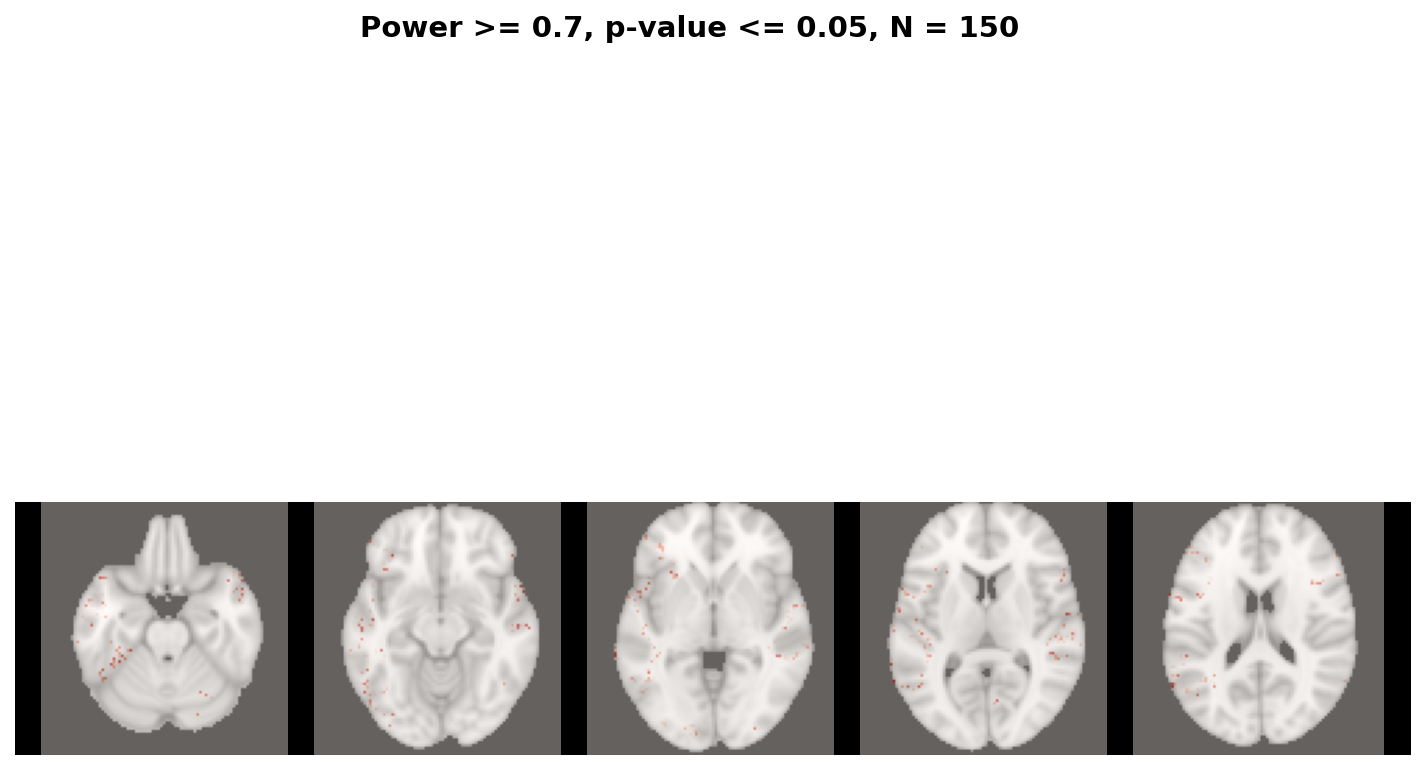

In [7]:
# Define the activation files
activation_files = [
    'images/PValContrast_N150_p05_Power70_f203.nii.gz'
]

# Load the anatomical image
img = nib.load('anatomical.nii.gz')
data = img.get_fdata()

# Define slices to extract
slices_indices = [24, 30, 35, 40, 45]

# Set up the figure
fig, axes = plt.subplots(len(activation_files), len(slices_indices), figsize=(12, 9), dpi=150)

# Loop through activation files
for row, activation_file in enumerate(activation_files):
    # Load activation data
    activation = nib.load(activation_file)
    activation_data = activation.get_fdata()
    
    # Extract metadata from filename
    match = re.search(r'images/PowerContrast_N(\d+)_p(\d+)_Power(\d+)_f2(\d+)', activation_file)
    if match:
        f_value = float(match.group(4)) / 10
        n_value = match.group(1)
        p_value = float(match.group(2)) / 100
        power_value = float(match.group(3)) / 100
        title_text = f"Power >= {power_value}, p-value <= {p_value}, N = {n_value}"
    else:
        f_value = None
    
    # Loop through slices
    for col, slice_idx in enumerate(slices_indices):
        slice_img = data[:, :, slice_idx]
        activation_img = activation_data[:, :, slice_idx]
        
        # Rotate images by 90 degrees
        rotated_slice = np.flip(rotate(slice_img, 90, reshape=False, mode='constant', cval=0), axis=1)
        rotated_activation = np.flip(rotate(activation_img, 90, reshape=False, mode='constant', cval=0), axis=1)

        
        ax = axes[row, col] if len(activation_files) > 1 else axes[col]
        ax.imshow(rotated_slice, cmap='gray')
        ax.imshow(np.ma.masked_where(rotated_activation == 0, rotated_activation), cmap='Reds', alpha=0.4)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_frame_on(False)
        
        # Set y-axis titles
        if col == 0 and f_value is not None:
            ax.set_ylabel(f"F² = {f_value}", fontsize=10, fontweight='bold')

fig.suptitle(title_text, fontsize=14, fontweight='bold', y=0.95)
plt.subplots_adjust(wspace=-0.1, hspace=0.1)
plt.show()


# Activation Maps - Second Generation P-Val

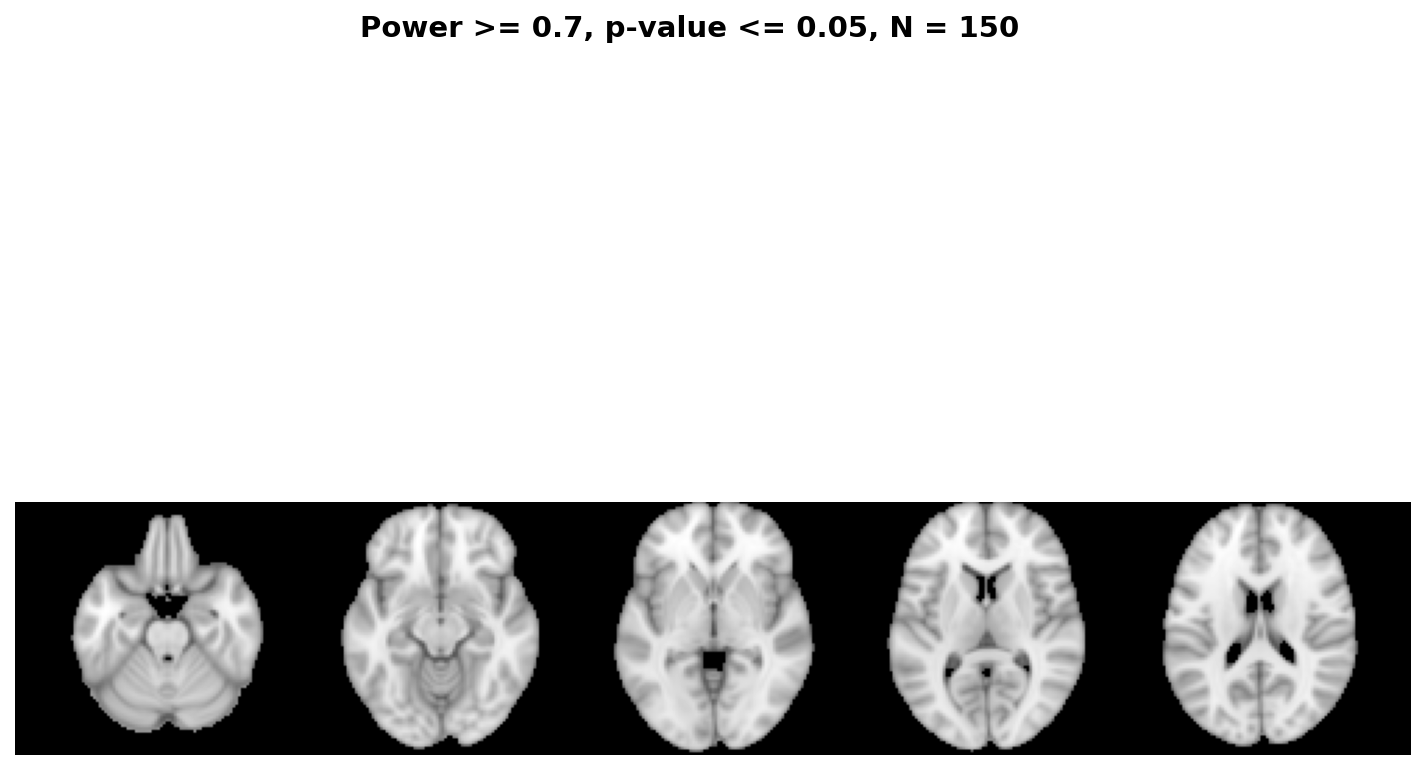

In [8]:
# Define the activation files
activation_files = [
    'images/SecGenPValContrast_N150_p05_Power70_f203.nii.gz'
]

# Load the anatomical image
img = nib.load('anatomical.nii.gz')
data = img.get_fdata()

# Define slices to extract
slices_indices = [24, 30, 35, 40, 45]

# Set up the figure
fig, axes = plt.subplots(len(activation_files), len(slices_indices), figsize=(12, 9), dpi=150)

# Loop through activation files
for row, activation_file in enumerate(activation_files):
    # Load activation data
    activation = nib.load(activation_file)
    activation_data = activation.get_fdata()
    
    # Extract metadata from filename
    match = re.search(r'images/PowerContrast_N(\d+)_p(\d+)_Power(\d+)_f2(\d+)', activation_file)
    if match:
        f_value = float(match.group(4)) / 10
        n_value = match.group(1)
        p_value = float(match.group(2)) / 100
        power_value = float(match.group(3)) / 100
        title_text = f"Power >= {power_value}, p-value <= {p_value}, N = {n_value}"
    else:
        f_value = None
    
    # Loop through slices
    for col, slice_idx in enumerate(slices_indices):
        slice_img = data[:, :, slice_idx]
        activation_img = activation_data[:, :, slice_idx]
        
        # Rotate images by 90 degrees
        rotated_slice = np.flip(rotate(slice_img, 90, reshape=False, mode='constant', cval=0), axis=1)
        rotated_activation = np.flip(rotate(activation_img, 90, reshape=False, mode='constant', cval=0), axis=1)

        
        ax = axes[row, col] if len(activation_files) > 1 else axes[col]
        ax.imshow(rotated_slice, cmap='gray')
        ax.imshow(np.ma.masked_where(rotated_activation == 0, rotated_activation), cmap='Reds', alpha=0.4)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_frame_on(False)
        
        # Set y-axis titles
        if col == 0 and f_value is not None:
            ax.set_ylabel(f"F² = {f_value}", fontsize=10, fontweight='bold')

fig.suptitle(title_text, fontsize=14, fontweight='bold', y=0.95)
plt.subplots_adjust(wspace=-0.1, hspace=0.1)
plt.show()


# Get All Values for Plots

In [9]:
# Load fMRI images
MNIAtlas = load_nii('anatomical.nii.gz')
Contrast = load_nii('language_uniformity-test_z_FDR_0.01.nii.gz')
#Contrast = load_nii('language_association_test_z_FDR_0.01.nii.gz')

# Extract image data
Contrast_img = Contrast.get_fdata()

# Compute max contrast
MaxContrast = np.max(Contrast_img)

for a in f2:
    # Scale contrast images
    Contrast_Scaled = (a / MaxContrast) * Contrast_img

    # Get image dimensions correctly
    XDIM, YDIM, ZDIM = Contrast_img.shape
    PowerImage = np.zeros((XDIM, YDIM, ZDIM))
    PvalImage = np.zeros((XDIM, YDIM, ZDIM))
    SecGenPvalImage = np.zeros((XDIM, YDIM, ZDIM))

    for n in Ns:
        for alpha in d:
            for i in range(XDIM):
                for j in range(YDIM):
                    for k in range(ZDIM):
                        if Contrast_Scaled[i, j, k] > 0:
                            stat_power, _ = power_calcs2(1, n, Contrast_Scaled[i, j, k], alpha, Contrast_img[i, j, k]) # only calculate power on non-0 values
                            _ , stat_pval = power_calcs2(1, n, Contrast_img[i, j, k], alpha, Contrast_img[i, j, k])
                            secgenpval = calculate_second_gen_p_value(Contrast_img[i, j, k], 0, Contrast_Scaled[i, j, k], n, alpha)
                            
                            # Power analysis
                            PowerImage[i, j, k] = stat_power #adjusts 3d matrix on values to only include power values that meet threshold (overwrites default zeros)
                            # Pval analysis
                            PvalImage[i, j, k] = stat_pval 
                            # Second Gen Pval analysis
                            SecGenPvalImage[i, j, k] = secgenpval 

            # Format filename correctly
            pvalue = str(alpha).replace('0.', '')
            f2value = str(a).replace('0.', '0')

            # Save power image as a NIfTI file
            power_filename = f'images/Ternary_PowerContrast_N{n}_p{pvalue}_Power{int(PowerThreshold * 100)}_f2{f2value}.nii.gz'
            print(power_filename)
            PowerImage_nii = nib.Nifti1Image(PowerImage, Contrast.affine, Contrast.header)
            nib.save(PowerImage_nii, power_filename)

            # Save pval image as a NIfTI file
            pval_filename = f'images/Ternary_PValContrast_N{n}_p{pvalue}_Power{int(PowerThreshold * 100)}_f2{f2value}.nii.gz'
            print(pval_filename)
            PvalImage_nii = nib.Nifti1Image(PvalImage, Contrast.affine, Contrast.header)
            nib.save(PvalImage_nii, pval_filename)

            # Save second gen pval image as a NIfTI file
            secgenpval_filename = f'images/Ternary_SecGenPValContrast_N{n}_p{pvalue}_Power{int(PowerThreshold * 100)}_f2{f2value}.nii.gz'
            print(secgenpval_filename)
            SecGenPvalImage_nii = nib.Nifti1Image(SecGenPvalImage, Contrast.affine, Contrast.header)
            nib.save(SecGenPvalImage_nii, secgenpval_filename)


images/Ternary_PowerContrast_N150_p05_Power70_f203.nii.gz
images/Ternary_PValContrast_N150_p05_Power70_f203.nii.gz
images/Ternary_SecGenPValContrast_N150_p05_Power70_f203.nii.gz


In [10]:
img = nib.load('images/Ternary_PValContrast_N150_p05_Power70_f203.nii.gz')
stat_pval = list(img.get_fdata().flatten())

img = nib.load('images/Ternary_PowerContrast_N150_p05_Power70_f203.nii.gz')
power = list(img.get_fdata().flatten())

img = nib.load('images/Ternary_SecGenPValContrast_N150_p05_Power70_f203.nii.gz')
sec_gen_pval = list(img.get_fdata().flatten())



df = pd.DataFrame(list(zip(stat_pval, power, sec_gen_pval)), columns=['Statistical_Pval', 'Power', '2nd_Gen_Pval'])
df.head()

,Statistical_Pval,Power,2nd_Gen_Pval
0,0.0,0.0,0.0
1,0.0,0.0,0.0
2,0.0,0.0,0.0
3,0.0,0.0,0.0
4,0.0,0.0,0.0


In [11]:
df.describe() #2nd Gen Pval all 0s

,Statistical_Pval,Power,2nd_Gen_Pval
count,902629.000000,902629.000000,902629.0
mean,0.000007,0.029865,0.0
std,0.000105,0.154892,0.0
min,0.000000,0.000000,0.0
25%,0.000000,0.000000,0.0
50%,0.000000,0.000000,0.0
75%,0.000000,0.000000,0.0
max,0.002017,1.000000,0.0


In [12]:
# Identify rows with all zeros
rows_to_drop = (df == 0).all(axis=1)

# Remove rows with all zeros
df1 = df[~rows_to_drop]

In [13]:
df1.describe()

,Statistical_Pval,Power,2nd_Gen_Pval
count,3.365500e+04,33655.000000,33655.0
mean,1.998608e-04,0.800993,0.0
std,5.085357e-04,0.160585,0.0
min,0.000000e+00,0.523711,0.0
25%,0.000000e+00,0.651823,0.0
50%,6.127920e-09,0.816235,0.0
75%,4.526067e-05,0.961602,0.0
max,2.016691e-03,1.000000,0.0


In [14]:
df1['2nd_Gen_Pval'] = np.random.uniform(0, 0.1, size=len(df1))

/var/folders/s8/mm0m1zj51zn4xbw55t3kxv7h0000gn/T/ipykernel_78583/1130009263.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['2nd_Gen_Pval'] = np.random.uniform(0, 0.1, size=len(df1))


In [15]:
df1.describe()

,Statistical_Pval,Power,2nd_Gen_Pval
count,3.365500e+04,33655.000000,33655.000000
mean,1.998608e-04,0.800993,0.049973
std,5.085357e-04,0.160585,0.028958
min,0.000000e+00,0.523711,0.000002
25%,0.000000e+00,0.651823,0.024861
50%,6.127920e-09,0.816235,0.050075
75%,4.526067e-05,0.961602,0.074979
max,2.016691e-03,1.000000,0.099999


In [16]:
#df1 = {'Statistical_Pval': [0, 0.1, 0.2, 0.3], 'Power': [0.5, 0.4, 0.7, 0.9], '2nd_Gen_Pval': [0.3, 0.5, 0.7, 0.1]}
#df1 = pd.DataFrame.from_dict(df1)

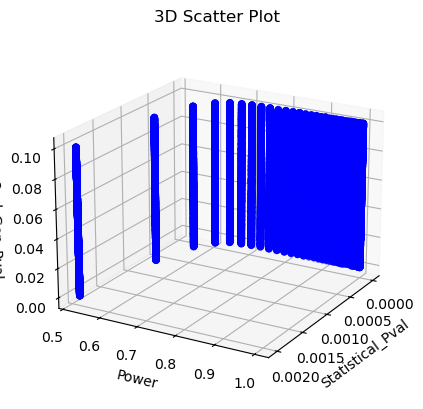

In [17]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_3d_scatter(df):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(df["Statistical_Pval"], df["Power"], df["2nd_Gen_Pval"], c='blue', marker='o')
    
    ax.set_xlabel("Statistical_Pval")
    ax.set_ylabel("Power")
    ax.set_zlabel("2nd_Gen_Pval")
    ax.set_title("3D Scatter Plot")

    ax.view_init(elev=20, azim=30)
    plt.show()

plot_3d_scatter(df1)

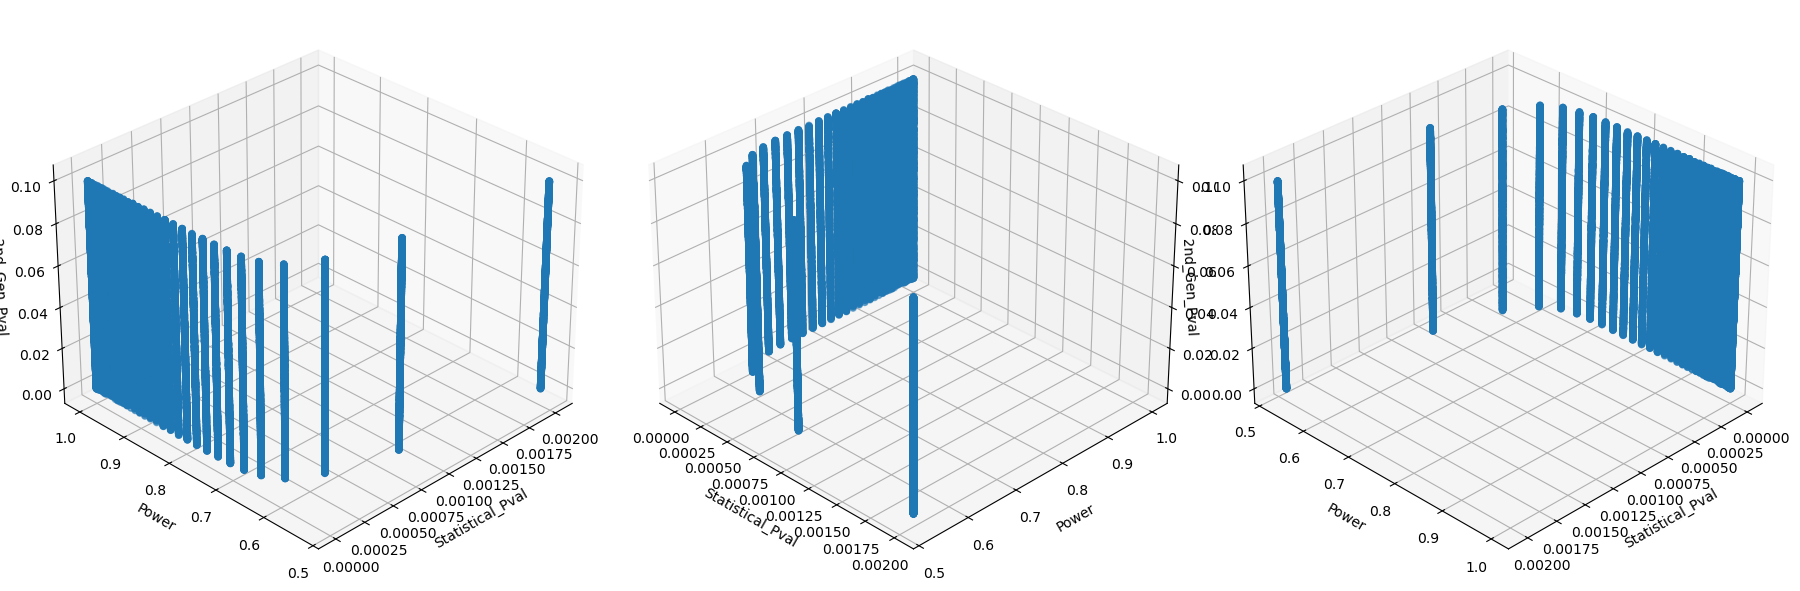

<Axes3D: xlabel='Statistical_Pval', ylabel='Power', zlabel='2nd_Gen_Pval'>

In [18]:
def my_scatter(data):

    fig = plt.figure(figsize=(18, 6))  # Adjusted figure size to accommodate 3 plots

    # First subplot: original viewing angle
    ax1 = fig.add_subplot(132, projection='3d', xlabel=data.columns[0], ylabel=data.columns[1], zlabel=data.columns[2])
    ax1.scatter(data.iloc[:, 0], data.iloc[:, 1], data.iloc[:, 2], s=20) # note it only shows the first 3 columns of the data
    ax1.view_init(elev=30, azim=-45)  # Rotate by another 90 degrees (180 degrees total)

    # Second subplot: rotated view by 90 degrees
    ax2 = fig.add_subplot(133, projection='3d', xlabel=data.columns[0], ylabel=data.columns[1], zlabel=data.columns[2])
    ax2.scatter(data.iloc[:, 0], data.iloc[:, 1], data.iloc[:, 2], s=20)
    ax2.view_init(elev=30, azim=ax1.azim+90)  # Rotate by 90 degrees

    # Third subplot: rotated view by 90 degrees in the opposite direction
    ax3 = fig.add_subplot(131, projection='3d', xlabel=data.columns[0], ylabel=data.columns[1], zlabel=data.columns[2])
    ax3.scatter(data.iloc[:, 0], data.iloc[:, 1], data.iloc[:, 2], s=20)
    ax3.view_init(elev=30, azim=ax1.azim-90)  # Rotate by another 90 degrees

    # Display the plot
    plt.tight_layout()
    plt.show()

    return ax1

# Run function
my_scatter(df1)

/opt/anaconda3/lib/python3.12/site-packages/ternary/plotting.py:148: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  ax.scatter(xs, ys, vmin=vmin, vmax=vmax, **kwargs)


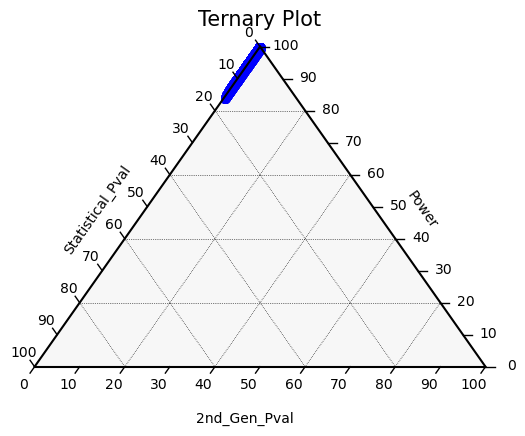

In [19]:
import pandas as pd
import ternary
import numpy as np

def normalize_ternary_data(df):
    df = df.copy()
    df = df.div(df.sum(axis=1), axis=0)  # Normalize so each row sums to 1
    return df

def plot_ternary(df1, min_val=0, max_val=1):
    scale = 100  # Use a larger scale for better tick representation
    df1 = normalize_ternary_data(df1) * scale  # Normalize and scale data
    data = list(zip(df1["Statistical_Pval"], df1["Power"], df1["2nd_Gen_Pval"]))
    
    # Set up ternary plot
    figure, tax = ternary.figure(scale=scale)
    tax.boundary(linewidth=1.5)
    
    # Generate ticks
    tick_values = np.linspace(0, scale, 11)  # Properly scaled tick values
    tax.ticks(ticks=list(tick_values), axis='lbr', linewidth=1, offset=0.02, fontsize=10, multiple=20)
    
    # Add gridlines
    tax.gridlines(multiple=20, color="black", linewidth=0.5)
    
    # Plot points
    tax.scatter(data, marker='o', color='blue', s=30)
    
    # Set axis labels
    tax.set_title("Ternary Plot", fontsize=15)
    tax.left_axis_label("Statistical_Pval", fontsize=10, offset=0.12)
    tax.right_axis_label("Power", fontsize=10, offset=0.12)
    tax.bottom_axis_label("2nd_Gen_Pval", fontsize=10, offset=0.12)
    
    # Hide default Matplotlib ticks
    tax.get_axes().axis('off')
    
    # Render the plot
    tax.show()

# Example usage:
# df1 should be a DataFrame with "Statistical_Pval", "Power", "2nd_Gen_Pval"
plot_ternary(df1, min_val=0, max_val=1)


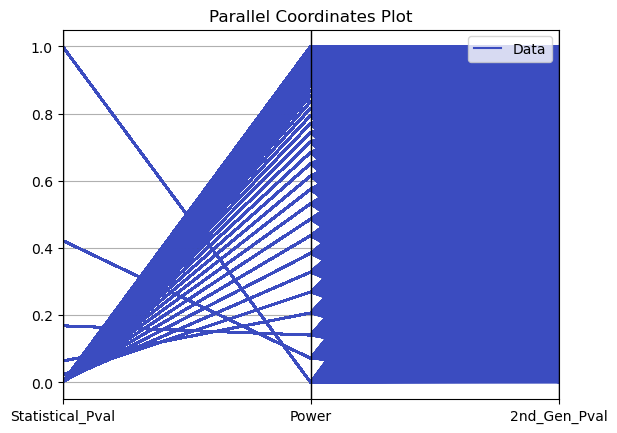

In [20]:
import pandas as pd
import seaborn as sns
from pandas.plotting import parallel_coordinates

def plot_parallel_coordinates(df):
    df_norm = (df - df.min()) / (df.max() - df.min())  # Normalize values
    df_norm["Category"] = "Data"  # Needed for the color grouping
    parallel_coordinates(df_norm, class_column="Category", colormap="coolwarm")
    plt.title("Parallel Coordinates Plot")
    plt.show()

plot_parallel_coordinates(df1)